In [1]:
import pandas as pd
from os import path
import matplotlib.pyplot as plt
from scipy import signal, interpolate
import numpy as np
import folium
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras


In [2]:
source_path = r"C:\Users\joses\Mi unidad\TRABAJO\49_profile_estimation\TRABAJO\experimental\bus_913\ordinal_regression"

win_len = 500

speed_stopped_th = 1. # m/s

# Data Extraction

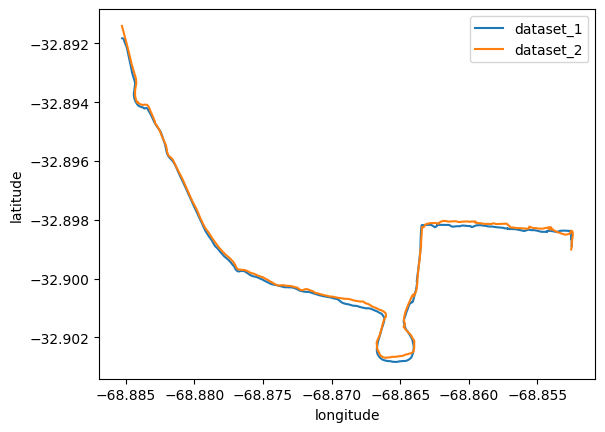

In [3]:
subtract_g = True
fs_acc = 100 # sps


def load_dataset_n(path_n: str, i_ini: int, i_fin: int, n_dataset: int = 0, subtract_g: bool = True, plot: bool = True):
    acc_orig_df_n = pd.read_csv(path.join(source_path, path_n, "AccelerometerUncalibrated.csv")).iloc[i_ini*fs_acc:i_fin*fs_acc, :].reset_index()
    if subtract_g:
        acc_orig_df_n['z'] = acc_orig_df_n['z'] - 9.81
    loc_orig_df_n = pd.read_csv(path.join(source_path, path_n, "Location.csv")).iloc[i_ini:i_fin, :].reset_index()
    loc_orig_df_n = loc_orig_df_n.loc[loc_orig_df_n['speed'] > speed_stopped_th].reset_index()

    if plot and 'loc_orig_df_1' in globals():
        plt.plot(loc_orig_df_1['longitude'], loc_orig_df_1['latitude'], label='dataset_1')
        plt.plot(loc_orig_df_n['longitude'], loc_orig_df_n['latitude'], label=f'dataset_{n_dataset}')
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.legend()
        plt.show()

    return loc_orig_df_n, acc_orig_df_n


# Dataset 1
i_ini, i_fin = 0, 690 # s
loc_orig_df_1, acc_orig_df_1 = load_dataset_n('913_3', i_ini, i_fin, 1, plot=False)

# Dataset 2
i_ini, i_fin = 35, 800 # s
loc_orig_df_2, acc_orig_df_2 = load_dataset_n('913_2', i_ini, i_fin, 2, plot=True)



## Raw Visualization

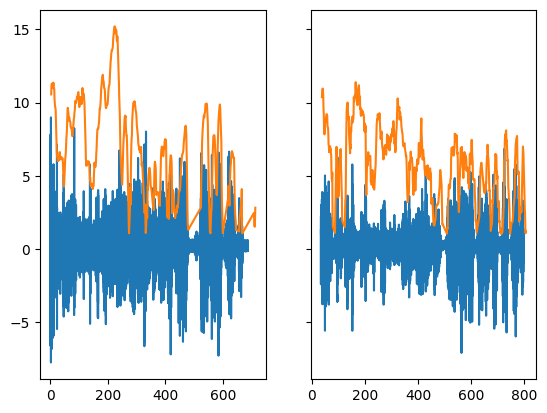

In [4]:
fig, ax = plt.subplots(1, 2, sharey='row')
ax[0].plot(acc_orig_df_1['seconds_elapsed'], acc_orig_df_1['z'])
ax[0].plot(loc_orig_df_1['seconds_elapsed'], loc_orig_df_1['speed'])
ax[1].plot(acc_orig_df_2['seconds_elapsed'], acc_orig_df_2['z'])
ax[1].plot(loc_orig_df_2['seconds_elapsed'], loc_orig_df_2['speed'])

# Feature extraction

In [5]:
# RMS of acceleration
def rolling_rms(acc_orig_df):
    acc2_cum = np.cumsum(acc_orig_df['z']**2)
    acc_rms = np.zeros(acc_orig_df.shape[0])
    for i in range(acc_orig_df.shape[0]-win_len):
        acc_rms[i+win_len] = np.sqrt((acc2_cum[i+win_len] - acc2_cum[i])/win_len)
    acc_feat_df = pd.DataFrame(data=np.vstack((acc_orig_df['seconds_elapsed'].values, acc_rms)).T, 
                                columns=['seconds_elapsed', 'z_rolling_rms']).fillna(0)
    acc_feat_df.reset_index(inplace=True)
    first_non_zero = np.nonzero(acc_feat_df['z_rolling_rms'].values)[0][0]
    acc_feat_df['z_rolling_rms'].values[:first_non_zero] = acc_feat_df['z_rolling_rms'].values[first_non_zero]
    return acc_feat_df

acc_feat_df_1, acc_feat_df_2 = rolling_rms(acc_orig_df_1), rolling_rms(acc_orig_df_2)


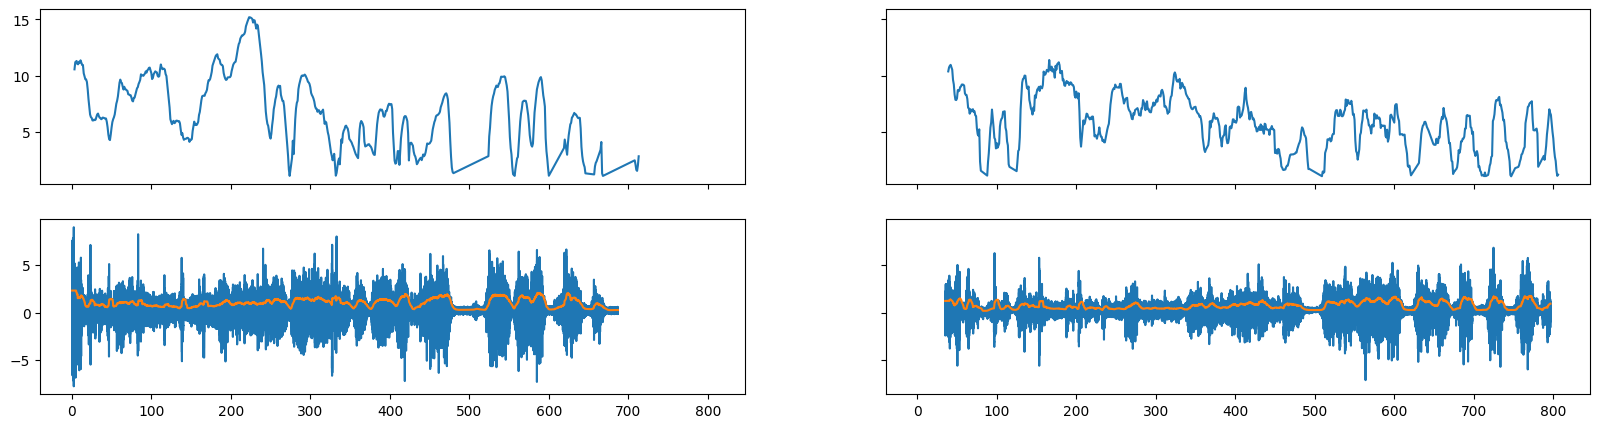

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(20, 5), sharex='all', sharey='row')
ax[0,0].plot(loc_orig_df_1['seconds_elapsed'], loc_orig_df_1['speed'])
ax[1,0].plot(acc_orig_df_1['seconds_elapsed'], acc_orig_df_1['z'])
ax[1,0].plot(acc_feat_df_1['seconds_elapsed'], acc_feat_df_1['z_rolling_rms'])
# ax[1,0].set_xlim([0, 200])
ax[0,1].plot(loc_orig_df_2['seconds_elapsed'], loc_orig_df_2['speed'])
ax[1,1].plot(acc_orig_df_2['seconds_elapsed'], acc_orig_df_2['z'])
ax[1,1].plot(acc_feat_df_2['seconds_elapsed'], acc_feat_df_2['z_rolling_rms'])
# ax[1,1].set_xlim([0, 60])
plt.show()

### Scatter analysis

#### Low frequency

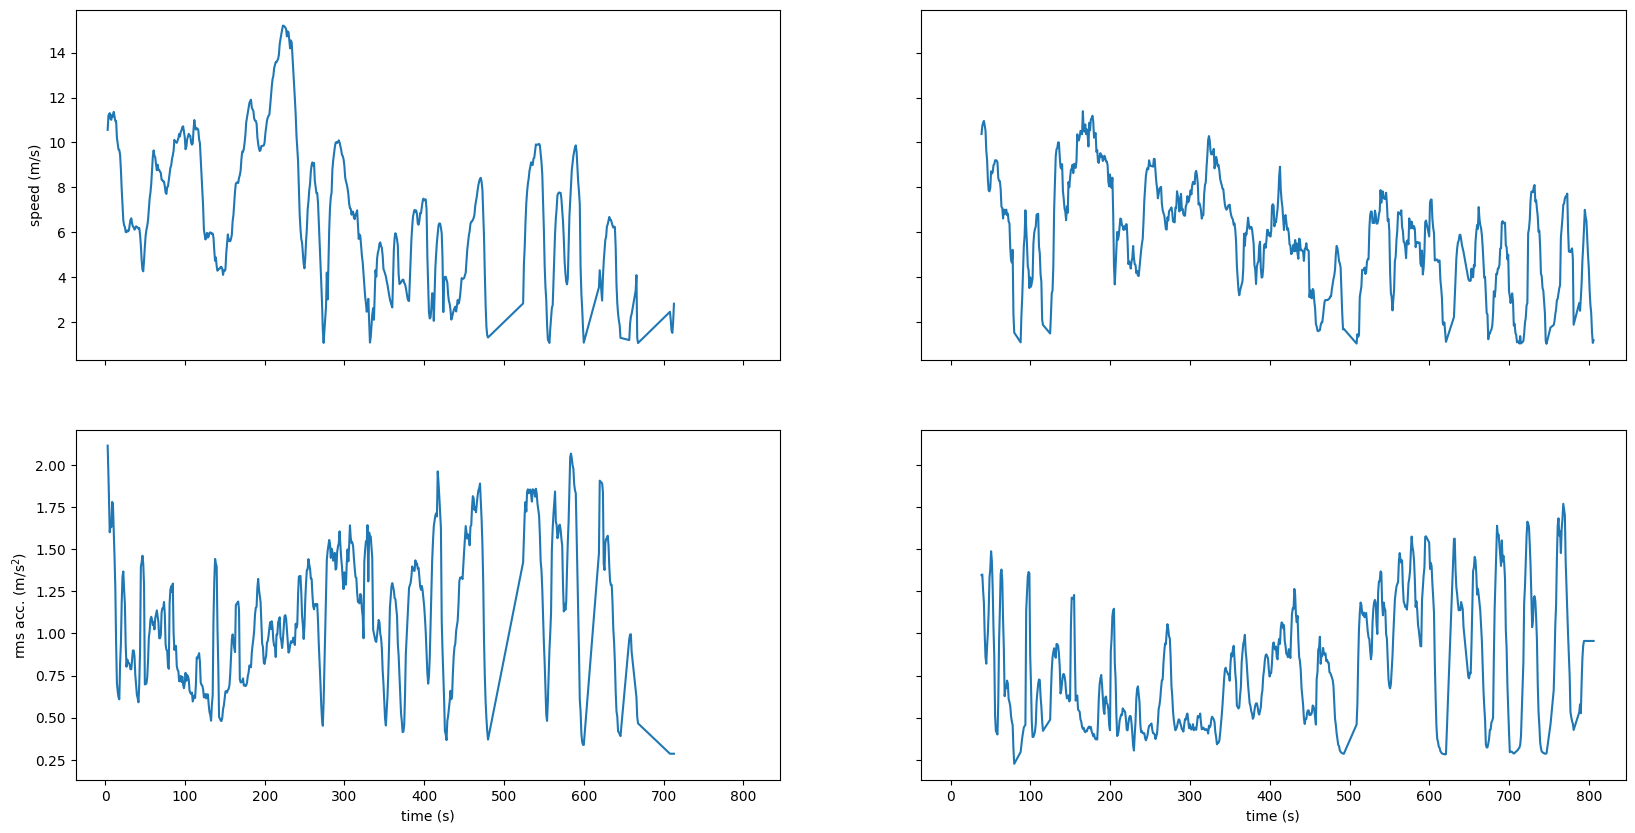

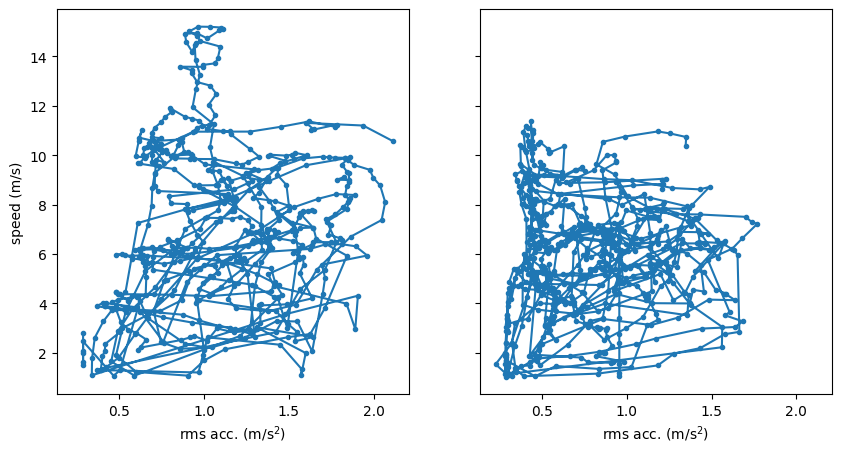

In [7]:
def calc_features_lf_n(loc_orig_df_n, acc_feat_df_n):
    features_lf_n = loc_orig_df_n.loc[:, :]
    features_lf_n['z_rolling_rms'] = \
    np.interp(x=loc_orig_df_n['seconds_elapsed'], 
              xp=acc_feat_df_n['seconds_elapsed'].values-((win_len/fs_acc)/2), fp=acc_feat_df_n['z_rolling_rms'])
    features_lf_n = features_lf_n.drop(columns=['level_0']).reset_index()
    return features_lf_n


features_lf_1, features_lf_2 = calc_features_lf_n(loc_orig_df_1, acc_feat_df_1), calc_features_lf_n(loc_orig_df_2, acc_feat_df_2)


fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex='all', sharey='row')
ax[0,0].plot(features_lf_1['seconds_elapsed'], features_lf_1['speed'])
ax[0,0].set_ylabel('speed (m/s)')
ax[1,0].plot(features_lf_1['seconds_elapsed'], features_lf_1['z_rolling_rms'])
ax[1,0].set_ylabel('rms acc. (m/s$^2$)')
ax[0,1].plot(features_lf_2['seconds_elapsed'], features_lf_2['speed'])
ax[1,1].plot(features_lf_2['seconds_elapsed'], features_lf_2['z_rolling_rms'])
ax[1,0].set_xlabel('time (s)')
ax[1,1].set_xlabel('time (s)')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex='all', sharey='all')
ax[0].plot(features_lf_1['z_rolling_rms'], features_lf_1['speed'], linestyle='-', marker='.')
ax[0].set_xlabel('rms acc. (m/s$^2$)')
ax[0].set_ylabel('speed (m/s)')
ax[1].plot(features_lf_2['z_rolling_rms'], features_lf_2['speed'], linestyle='-', marker='.')
ax[1].set_xlabel('rms acc. (m/s$^2$)')
plt.show()

### Location matching

In [8]:
def times_matches_1_n(loc_orig_df_1, loc_orig_df_n, features_lf_n):
    # Extract coordinates as arrays
    coords_orig = loc_orig_df_1[['latitude', 'longitude']].values
    coords_dest = loc_orig_df_n[['latitude', 'longitude']].values

    # Compute pairwise distances
    distances = cdist(coords_orig, coords_dest, metric='euclidean')

    # Find the nearest point for each origin point
    nearest_indices = distances.argmin(axis=1)
    nearest_distances = distances.min(axis=1)

    # Build a dictionary of time matches
    time_matches_dict = {}
    for i, (dist, idx) in enumerate(zip(nearest_distances, nearest_indices)):
        orig_time = loc_orig_df_1.iloc[i]['seconds_elapsed']
        dest_time = loc_orig_df_n.iloc[idx]['seconds_elapsed']
        time_matches_dict[orig_time] = dest_time

    # location matching
    loc_orig_df_n_matched = loc_orig_df_1.copy()
    for index, row in loc_orig_df_1.iterrows():
        seconds_elapsed_1 = row['seconds_elapsed']
        if index == len(loc_orig_df_n_matched):
            break
        loc_orig_df_n_matched.iloc[index] = loc_orig_df_n.loc[loc_orig_df_n['seconds_elapsed'] == time_matches_dict[seconds_elapsed_1]].values[0]

    # feature matching
    features_lf_n_matched = features_lf_1.copy()
    for index, row in features_lf_1.iterrows():
        seconds_elapsed_1 = row['seconds_elapsed']
        features_lf_n_matched.iloc[index] = features_lf_n.loc[features_lf_n['seconds_elapsed'] == time_matches_dict[seconds_elapsed_1]].values[0]

    return time_matches_dict, loc_orig_df_n_matched, features_lf_n_matched


time_matches_dict, loc_orig_df_2_matched, features_lf_2_matched = times_matches_1_n(loc_orig_df_1, loc_orig_df_2, features_lf_2)


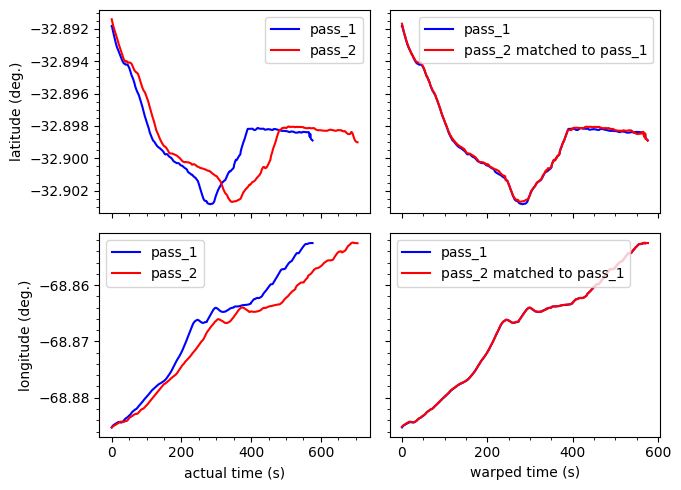

In [9]:

fig, ax = plt.subplots(2, 2, figsize=(7, 5), sharey='row', sharex='col')

ax[0,0].plot(loc_orig_df_1['latitude'].values, color='blue', label='pass_1')
ax[0,0].plot(loc_orig_df_2['latitude'].values, color='red', label='pass_2')
ax[1,0].plot(loc_orig_df_1['longitude'].values, color='blue', label='pass_1')
ax[1,0].plot(loc_orig_df_2['longitude'].values, color='red',  label='pass_2')


ax[0,1].plot(loc_orig_df_1['latitude'].values, color='blue', label='pass_1')
ax[0,1].plot(loc_orig_df_2_matched['latitude'].values, color='red',  label='pass_2 matched to pass_1')
ax[1,1].plot(loc_orig_df_1['longitude'].values, color='blue', label='pass_1')
ax[1,1].plot(loc_orig_df_2_matched['longitude'].values, color='red',  label='pass_2 matched to pass_1')

ax[0,0].set_ylabel('latitude (deg.)')
ax[1,0].set_ylabel('longitude (deg.)')
ax[1,0].set_xlabel('actual time (s)')
ax[1,1].set_xlabel('warped time (s)')

for __ in ax:
    for _ in __:
        _.minorticks_on()
        _.legend()

fig.tight_layout()
plt.show()
fig.savefig('location_based_dtw.pdf')

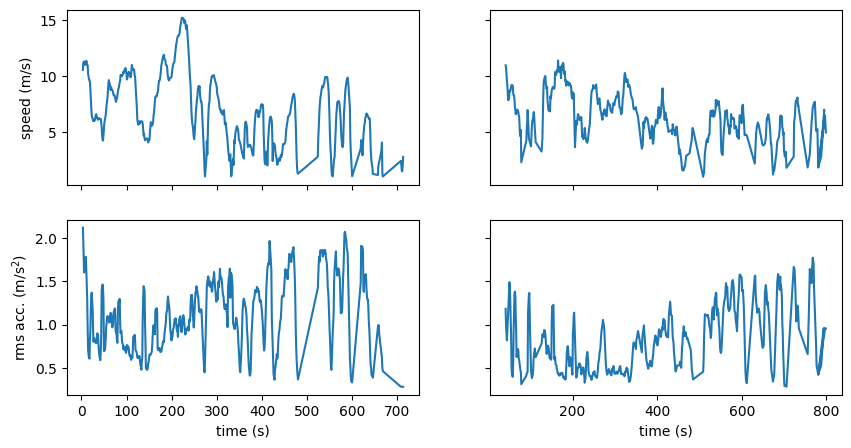

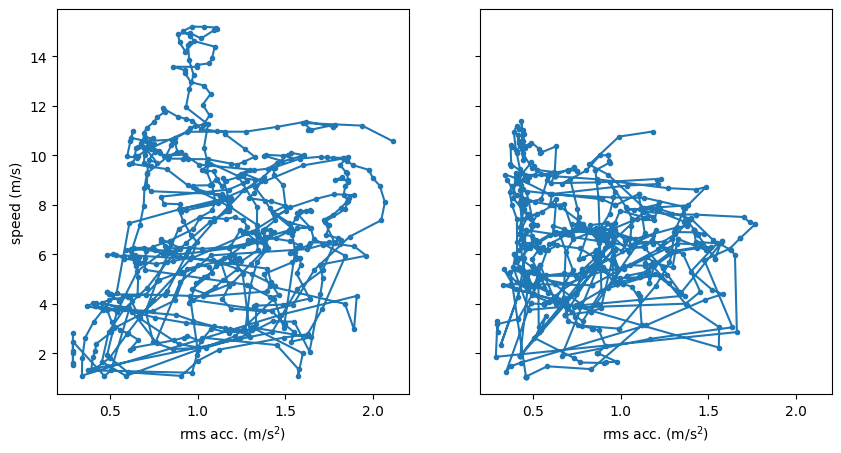

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='col', sharey='row')
ax[0,0].plot(features_lf_1['seconds_elapsed'], features_lf_1['speed'])
ax[0,0].set_ylabel('speed (m/s)')
ax[1,0].plot(features_lf_1['seconds_elapsed'], features_lf_1['z_rolling_rms'])
ax[0,1].plot(features_lf_2_matched['seconds_elapsed'], features_lf_2_matched['speed'])
ax[1,1].plot(features_lf_2_matched['seconds_elapsed'], features_lf_2_matched['z_rolling_rms'])
ax[1,0].set_ylabel('rms acc. (m/s$^2$)')
ax[1,0].set_xlabel('time (s)')
ax[1,1].set_xlabel('time (s)')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex='all', sharey='all')
ax[0].plot(features_lf_1['z_rolling_rms'], features_lf_1['speed'], linestyle='-', marker='.')
ax[0].set_xlabel('rms acc. (m/s$^2$)')
ax[0].set_ylabel('speed (m/s)')
ax[1].plot(features_lf_2_matched['z_rolling_rms'], features_lf_2_matched['speed'], linestyle='-', marker='.')
ax[1].set_xlabel('rms acc. (m/s$^2$)')
plt.show()

# Training

### Datasets

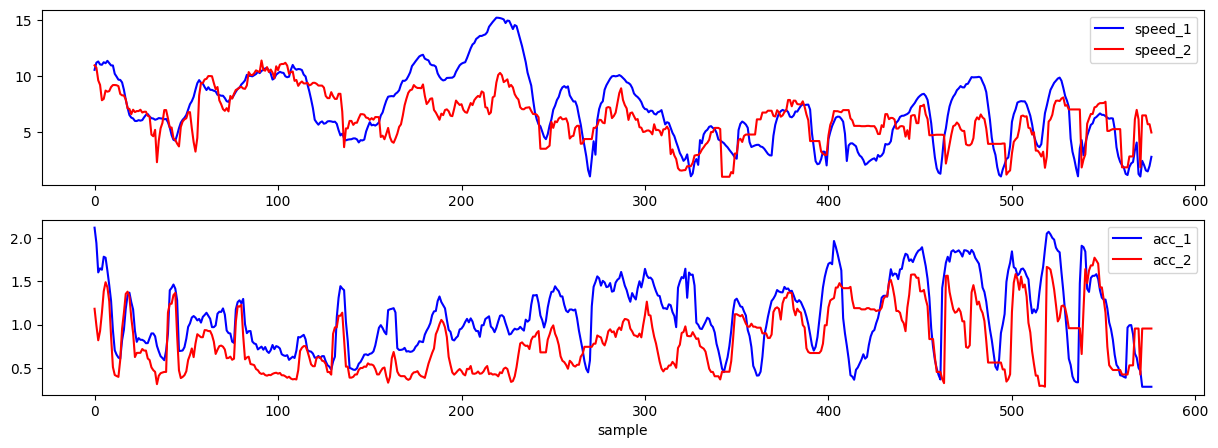

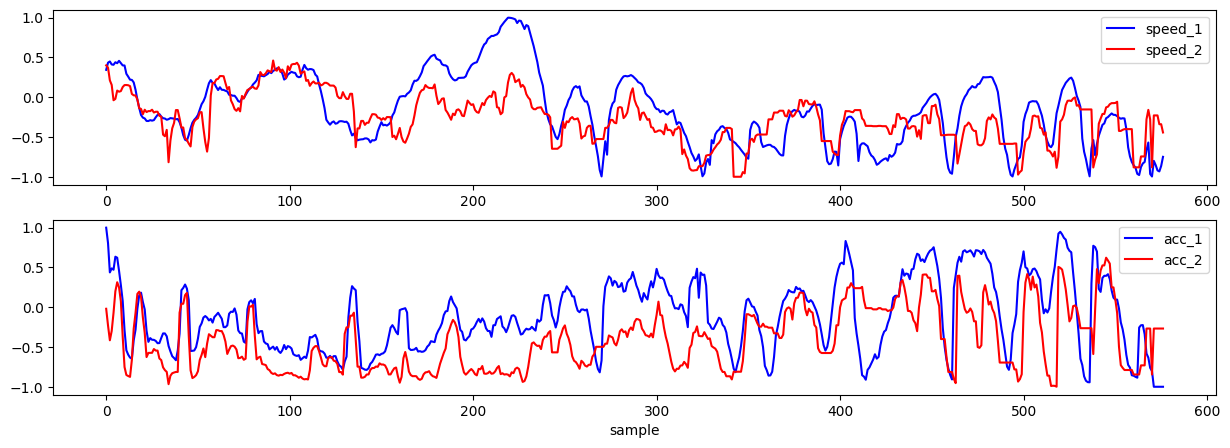

In [11]:
X_equal = np.array([features_lf_1.loc[:, 'speed'].values, features_lf_1.loc[:, 'z_rolling_rms'].values, 
                    features_lf_2_matched.loc[:, 'speed'].values, features_lf_2_matched.loc[:, 'z_rolling_rms'].values]).T
y_equal = np.zeros((X_equal.shape[0], 1))

fig, ax = plt.subplots(2, 1, figsize=(15,5))
ax[0].plot(X_equal[:, 0], color='blue', linestyle='-', label='speed_1')
ax[0].plot(X_equal[:, 2], color='red', linestyle='-', label='speed_2')
ax[0].legend()
ax[1].plot(X_equal[:, 1], color='blue', linestyle='-', label='acc_1')
ax[1].plot(X_equal[:, 3], color='red', linestyle='-', label='acc_2')
ax[1].set_xlabel('sample')
ax[1].legend()

scaler_X = MinMaxScaler((-1,1))
scaler_X.fit(np.vstack((X_equal[:, :2], X_equal[:, 2:])))
X_equal = np.hstack((scaler_X.transform(X_equal[:, :2]), scaler_X.transform(X_equal[:, 2:])))

fig, ax = plt.subplots(2, 1, figsize=(15,5))
ax[0].plot(X_equal[:, 0], color='blue', linestyle='-', label='speed_1')
ax[0].plot(X_equal[:, 2], color='red', linestyle='-', label='speed_2')
ax[0].legend()
ax[1].plot(X_equal[:, 1], color='blue', linestyle='-', label='acc_1')
ax[1].plot(X_equal[:, 3], color='red', linestyle='-', label='acc_2')
ax[1].set_xlabel('sample')
ax[1].legend()

#### Ordinal labels

S_e (577, 4)
S_g and S_l (71, 4)


(array([ 2.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  1.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

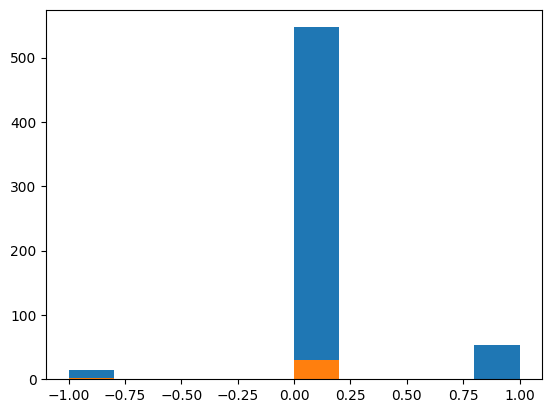

In [12]:
speed_tol = .01 # 
acc_tol = .01 # 

# grid_length = X_equal.shape[0]
# speed_grid = np.random.uniform(min([min(X_equal[:,0]), min(X_equal[:,2])]), max([max(X_equal[:,0]), max(X_equal[:,2])]), (grid_length,1))
# vib_grid = np.random.uniform(min([min(X_equal[:,1]), min(X_equal[:,3])]), max([max(X_equal[:,1]), max(X_equal[:,3])]), (grid_length,1))
# X_grid = np.hstack((speed_grid, vib_grid, speed_grid, vib_grid))

X_grid = X_equal
print('S_e', X_equal.shape)


X_ordinal = []
y_ordinal = []
for x1 in X_grid[:, :2]:
    for x2 in X_grid[:, 2:]:
        if abs(x1[0] - x2[0]) < speed_tol:
            if x1[1] > x2[1] + acc_tol:
                X_ordinal.append(np.hstack((x1, x2)))
                y_ordinal.append(1.)
            elif x1[1] < x2[1] - acc_tol:
                X_ordinal.append(np.hstack((x1, x2)))
                y_ordinal.append(-1.)
X_ordinal = np.array(X_ordinal)
y_ordinal = np.array(y_ordinal).reshape((-1, 1))

X_ordinal, _, y_ordinal, _ = train_test_split(X_ordinal, y_ordinal, test_size=0.985, shuffle=True)
print('S_g and S_l', X_ordinal.shape)


X = np.vstack((X_equal, X_ordinal))
y = np.vstack((y_equal, y_ordinal))
shuffler = np.arange(X.shape[0])
np.random.default_rng().shuffle(shuffler)
X = X[shuffler, :]
y = y[shuffler, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)

plt.hist(y_train)
plt.hist(y_test)

## Model definition

In [13]:
x1_nn_input = keras.layers.Input(shape=(2,))
x2_nn_input = keras.layers.Input(shape=(2,))

activation = 'tanh'
reg = None
dropout = 0.
shared_layers = [keras.layers.Dense(100, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                #  keras.layers.Dropout(dropout),
                #  keras.layers.BatchNormalization(),
                 keras.layers.Dense(100, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                #  keras.layers.Dropout(dropout),
                #  keras.layers.BatchNormalization(),
                 keras.layers.Dense(100, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                #  keras.layers.Dropout(dropout),
                #  keras.layers.BatchNormalization(),
                 keras.layers.Dense(1, activation='linear', kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg)]
first = True
for layer in shared_layers:
    if first:
        x1_nn = layer(x1_nn_input)
        x2_nn = layer(x2_nn_input)
        first = False    
    else:
        x1_nn = layer(x1_nn)
        x2_nn = layer(x2_nn)

y_nn = keras.layers.Lambda(lambda x12: keras.backend.tanh(x12[0] - x12[1]), name='ranker')((x1_nn, x2_nn))

model = keras.models.Model(inputs=[x1_nn_input, x2_nn_input], outputs=[y_nn])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 100)                  300       ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 100)                  10100     ['dense[0][0]',           

In [14]:
keras.utils.plot_model(model, to_file='model.pdf',
                        show_shapes=True,
                        show_dtype=False,
                        show_layer_names=True,
                        expand_nested=True,
                        dpi=96,
                        layer_range=None,
                        show_layer_activations=True,
                        show_trainable=True)

In [15]:
model_x1 = keras.models.Model(inputs=[x1_nn_input], outputs=[x1_nn])
model_x1.build(input_shape=x1_nn_input.shape)
# model_x1.summary()

## Model training

In [16]:
# learning_rate = .1
# batch_size = X_train.shape[0]
# epochs = 100
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,
#                                               patience=50, verbose=1,min_lr=1e-6)
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

# model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss='mse')
# history = model.fit(x=[X_train[:, :2], X_train[:, 2:]], y=[y_train], batch_size=batch_size, epochs=epochs, 
#                     validation_data=[[X_test[:, :2], X_test[:, 2:]], [y_test]],
#                     callbacks=[reduce_lr, early_stopping])
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.legend()
# plt.show()

In [17]:
import os


directory = r'C:\Users\joses\Mi unidad\TRABAJO\49_profile_estimation\TRABAJO\experimental\bus_913\ordinal_regression'
# model.save(os.path.join(directory, 'model_913.keras'))
# model_x1.save(os.path.join(directory, 'model_x1_913.keras'))

model.load_weights(os.path.join(directory, 'model_913.keras'))
model_x1.load_weights(os.path.join(directory, 'model_x1_913.keras'))

## Test

In [18]:
import plotly.graph_objects as go


layout = go.Layout(width=800, height=600)
x1_nn_train_pred = model_x1.predict([X_train[:, :2]])
fig3 = go.Figure(data=go.Scatter3d(x=X_train[:, 0], y=X_train[:, 1], z=x1_nn_train_pred[:,0],
                                   mode='markers', marker=dict(size=5), name='train'), layout=layout)

x1_nn_test_pred = model_x1.predict([X_test[:, :2]])
fig3.add_trace(go.Scatter3d(x=X_test[:, 0], y=X_test[:, 1], z=x1_nn_test_pred[:,0],
                            mode='markers', marker=dict(size=5), name='test'))
fig3.show()

layout = go.Layout(width=800, height=600)
X1_mesh, X2_mesh = np.meshgrid(np.linspace(-1., 1., 20), np.linspace(-1, 1, 20))
x1_mesh, x2_mesh = np.ravel(X1_mesh).reshape((-1, 1)), np.ravel(X2_mesh).reshape((-1, 1))
X1_mesh = np.hstack((x1_mesh, x2_mesh))
y_mesh = model_x1.predict([X1_mesh])
fig4 = go.Figure(data=go.Scatter3d(x=x1_mesh.ravel(), y=x2_mesh.ravel(), z=y_mesh.ravel(),
                                   mode='markers', marker=dict(size=5)), layout=layout)
fig4.show()

layout = go.Layout(width=800, height=600)
X1_mesh, X2_mesh = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
x1_mesh, x2_mesh = np.ravel(X1_mesh).reshape((-1, 1)), np.ravel(X2_mesh).reshape((-1, 1))
X1_mesh = np.hstack((x1_mesh, x2_mesh))
y_mesh = model_x1.predict([X1_mesh])
X1_mesh_actual = scaler_X.inverse_transform(X1_mesh)
fig4 = go.Figure(data=go.Scatter3d(x=X1_mesh_actual[:, 0], 
                                   y=X1_mesh_actual[:, 1], z=y_mesh.ravel(),
                                   mode='markers', marker=dict(size=5)), layout=layout)
fig4.show()

2/2 [==============================] - 1s 11ms/step


13/13 [==============================] - 1s 8ms/step


13/13 [==============================] - 1s 13ms/step


1/1 [==============================] - 0s 122ms/step


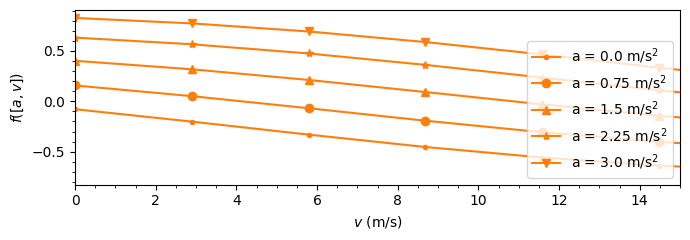

In [19]:
accs_plot = np.linspace(0, 3, 5)
speeds_plot = np.linspace(0, 55, 20)
fig, ax = plt.subplots(1, 1, figsize=(7,2.5), sharex='col')
markers = ['.', 'o', '^', '*', 'v']
for acc, marker in zip(accs_plot, markers):
    X_test_speed = np.hstack((speeds_plot.reshape((-1, 1)), np.zeros((speeds_plot.shape[0], 1)) + acc))
    ax.plot(speeds_plot, model_x1.predict(scaler_X.transform(X_test_speed)), label=f'a = {acc} '+ r'm/s$^{2}$',
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], marker=marker)
ax.set_xlabel(r'$v$ (m/s)')
ax.set_ylabel(r'$f([a, v])$')
ax.set_xlim((0,15))
# ax.set_ylim((0,.01))
ax.minorticks_on()
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()
fig.savefig('plot_f_real_world.pdf')

## Robustness testing

In [20]:
indices = [43, 100, 190, 220, 460, 540]


19/19 [==============================] - 0s 5ms/step


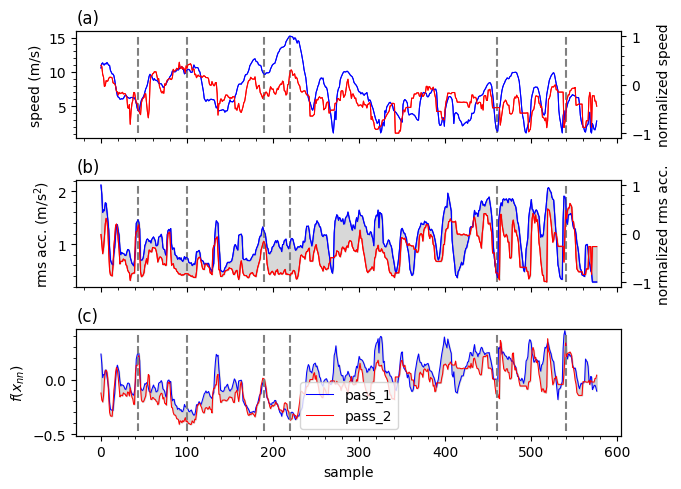

In [21]:
X_equal_actual = np.array([features_lf_1.loc[:, 'speed'].values, features_lf_1.loc[:, 'z_rolling_rms'].values, 
              features_lf_2_matched.loc[:, 'speed'].values, features_lf_2_matched.loc[:, 'z_rolling_rms'].values]).T
y_equal = np.zeros((X_equal.shape[0], 1))

X_equal = np.hstack((scaler_X.transform(X_equal_actual[:, :2]), scaler_X.transform(X_equal_actual[:, 2:])))

x1_1_pred = model_x1.predict([X_equal[:, :2]])
x1_2_pred = model_x1.predict([X_equal[:, 2:]])

fig, ax = plt.subplots(3, 1, figsize=(7,5), sharex='col')

ax_twin = []
for i, _ in enumerate(ax):
    _.minorticks_on()
    ax_twin.append(_.twinx())
    ax_twin[-1].minorticks_on()
ax_twin[2].set_yticks([])

for _ in ax_twin:
    for idx in indices:
        _.plot([idx, idx], [-1, 1], linestyle='--', color='gray')

ax_twin[0].plot(X_equal[:, 0], color='blue', linestyle='-', linewidth=0.75)
ax_twin[0].plot(X_equal[:, 2], color='red', linestyle='-', linewidth=0.75)
ax[0].plot(X_equal_actual[:, 0], color='blue', label='pass_1', linewidth=0.75)
ax[0].plot(X_equal_actual[:, 2], color='red', label='pass_2', linewidth=0.75)
ax[0].set_ylabel('speed (m/s)')
ax_twin[0].set_ylabel('normalized speed')
# ax[0].legend()
ax_twin[1].plot(X_equal[:, 1], color='blue', linestyle='-', linewidth=0.75)
ax_twin[1].plot(X_equal[:, 3], color='red', linestyle='-', linewidth=0.75)
ax[1].plot(X_equal_actual[:, 1], color='blue', linestyle='-', label='pass_1', linewidth=0.75)
ax[1].plot(X_equal_actual[:, 3], color='red', linestyle='-', label='pass_2', linewidth=0.75)
ax[1].fill_between(np.linspace(0,x1_1_pred.shape[0]-1,x1_1_pred.shape[0]), 
                   (X_equal_actual[:, 1]).ravel(), 
                   (X_equal_actual[:, 3]).ravel(), 
                   color='grey', alpha=0.3)  # Adjust alpha for transparency if needed
ax[1].set_ylabel(r'rms acc. (m/s$^2$)')
ax_twin[1].set_ylabel('normalized rms acc.')
# ax[1].legend()
ax[2].plot(x1_1_pred, color='blue', linestyle='-', label='pass_1', linewidth=0.75)
ax[2].plot(x1_2_pred, color='red', linestyle='-', label='pass_2', linewidth=0.75)
ax[2].fill_between(np.linspace(0,x1_1_pred.shape[0]-1,x1_1_pred.shape[0]), 
                   (x1_1_pred).ravel(), 
                   (x1_2_pred).ravel(), 
                   color='grey', alpha=0.3)  # Adjust alpha for transparency if needed
ax[2].set_ylabel(r'$f(x_{nn})$')
ax[2].legend(loc='lower center', )
ax[2].set_xlabel('sample')
ax[2].set_ylim([np.mean((x1_1_pred+x1_2_pred)/2)-3*np.std((x1_1_pred+x1_2_pred)/2), 
                np.mean((x1_1_pred+x1_2_pred)/2)+3*np.std((x1_1_pred+x1_2_pred)/2)])
_ = [ax[i].set_title('(' + chr(ord('a')+i) + ')', loc='left') for i in range(3)]
plt.tight_layout()
plt.savefig('reg_results'+'.pdf')
plt.show()

#### Maps

In [22]:
circ_rad = 10

# Create a map centered at the mean latitude and longitude of loc_orig_df_2
center_lat = loc_orig_df_1['latitude'].mean()
center_lon = loc_orig_df_1['longitude'].mean()
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')

f1, f2 = x1_1_pred[:,0], x1_2_pred[:,0]
f1, f2 = f1-np.min(f1), f2-np.min(f2)
f1, f2 = f1/np.max(f1), f2/np.max(f2)

# Plot the latitude and longitude data on the map
for index in range(loc_orig_df_1.shape[0]):
    row1, row2 = loc_orig_df_1.iloc[index,:], loc_orig_df_2_matched.iloc[index,:]
    folium.Circle([row1['latitude'], row1['longitude']],
                        radius=circ_rad*f1[index],
                        color='blue',
                        fill=False,
                        fill_color='blue').add_to(mymap)
    folium.Circle([row2['latitude'], row2['longitude']],
                        radius=circ_rad*f2[index],
                        color='red',
                        fill=False,
                        fill_color='red').add_to(mymap)
    
    # Add sample numbers every 10th point
    if index % 100 == 0:
        folium.Marker(
            [row1['latitude'], row1['longitude']],
            icon=folium.DivIcon(html=f"""<div style="font-size: 12pt; color : gray"><b>{index}</b></div>""")
        ).add_to(mymap)
    # and at:
    if index in indices:
        folium.Marker(
            [row1['latitude'], row1['longitude']],
            icon=folium.DivIcon(html=f"""<div style="font-size: 16pt; color : black"><b>{index}</b></div>""")
        ).add_to(mymap)
        print(f'sample {index}' + f"{(row1['latitude'], row1['longitude'])}, f1 = {x1_1_pred[index,0]}, f2 = {x1_2_pred[index,0]}, "
                                  f"f = {np.round(0.5*(x1_1_pred[index,0]+x1_2_pred[index,0]), 2)} "
                                  f"± {np.round((0.5*np.abs(x1_1_pred[index,0]-x1_2_pred[index,0])), 2)}; "
                                  f"{scaler_X.inverse_transform(X_equal[index, :2].reshape(1, -1)), scaler_X.inverse_transform(X_equal[index, 2:].reshape(1, -1))}")


# Save the map to an HTML file
mymap.save("map_f.html")



sample 43(-32.8942041, -68.8835737), f1 = 0.2534571886062622, f2 = 0.20397409796714783, f = 0.23 ± 0.02; (array([[4.34138107, 1.46200705]]), array([[4.47266388, 1.33991347]]))
sample 100(-32.8977337, -68.8798387), f1 = -0.25864720344543457, f2 = -0.37880581617355347, f = -0.32 ± 0.06; (array([[10.26542187,  0.74503203]]), array([[10.53293133,  0.43669244]]))
sample 190(-32.9002953, -68.8730501), f1 = -0.052624672651290894, f2 = 0.0032774750143289566, f = -0.02 ± 0.03; (array([[9.61803818, 1.223776  ]]), array([[6.53470945, 1.02716121]]))
sample 220(-32.9008631, -68.868933), f1 = -0.3258594572544098, f2 = -0.3734995722770691, f = -0.35 ± 0.02; (array([[15.18928242,  1.03701826]]), array([[10.10798073,  0.40569727]]))
sample 460(-32.8982391, -68.8598167), f1 = -0.002497278153896332, f2 = -0.1318751722574234, f = -0.07 ± 0.06; (array([[1.41982591, 0.42231078]]), array([[4.78907776, 0.45609985]]))
sample 540(-32.8983821, -68.8539608), f1 = 0.3995262384414673, f2 = 0.3610442280769348, f = 0

In [23]:
circ_rad = 5

# Create a map centered at the mean latitude and longitude of loc_orig_df_2
center_lat = loc_orig_df_1['latitude'].mean()
center_lon = loc_orig_df_1['longitude'].mean()
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')

acc1, acc2 = X_equal[:, 1], X_equal[:, 3]
acc1, acc2 = acc1-np.min(acc1), acc2-np.min(acc2)
acc1, acc2 = acc1/np.max(acc1), acc2/np.max(acc2)

# Plot the latitude and longitude data on the map
for index in range(loc_orig_df_1.shape[0]):
    row1, row2 = loc_orig_df_1.iloc[index,:], loc_orig_df_2_matched.iloc[index,:]
    folium.Circle([row1['latitude'], row1['longitude']],
                        radius=circ_rad*acc1[index],
                        color='blue',
                        fill=False,
                        fill_color='blue').add_to(mymap)
    folium.Circle([row2['latitude'], row2['longitude']],
                        radius=circ_rad*acc2[index],
                        color='red',
                        fill=False,
                        fill_color='red').add_to(mymap)

# Save the map to an HTML file
mymap.save("map_acc.html")

### Correlations

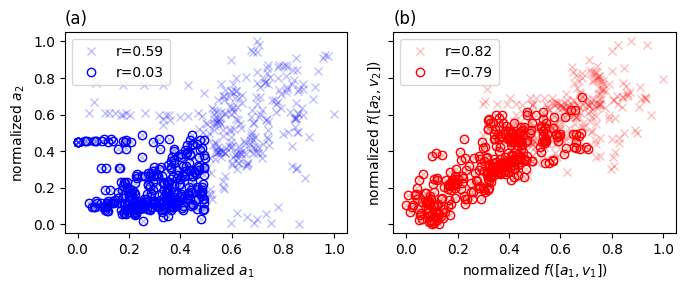

In [24]:
# acceleration correlation
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharex='all', sharey=all)
ax[0].plot(acc1, acc2, linestyle='', color='blue', marker='x', alpha=0.25, label=f'r={np.round(np.corrcoef(acc1, acc2)[1,0], 2)}')
ax[0].set_xlabel('acc_1')
ax[0].set_ylabel('acc_2')
ax[0].legend()
ax[1].plot(f1, f2, linestyle='', color='red', marker='x', alpha=0.25, label=f'r={np.round(np.corrcoef(f1, f2)[1,0], 2)}')
ax[1].set_xlabel('f_1')
ax[1].set_ylabel('f_2')
ax[1].legend()
# plt.show()


# acceleration correlation
acc_low_ = np.vstack((acc1, acc2)).T
acc_low = acc_low_[(acc_low_[:, 0] < 0.5) & (acc_low_[:, 1] < 0.5), :]
acc1_low, acc2_low = acc_low[:, 0], acc_low[:, 1]
f_low = np.vstack((f1, f2)).T
f_low = f_low[(acc_low_[:, 0] < 0.5) & (acc_low_[:, 1] < 0.5), :]
f1_low, f2_low = f_low[:, 0], f_low[:, 1]

ax[0].plot(acc1_low, acc2_low, linestyle='', color='blue', marker='o', markerfacecolor='none', label=f'r={np.round(np.corrcoef(acc1_low, acc2_low)[1,0], 2)}')
ax[0].set_xlabel('normalized $a_1$')
ax[0].set_ylabel('normalized $a_2$')
ax[0].legend()
ax[0].set_title('(a)', loc='left')
ax[1].plot(f1_low, f2_low, linestyle='', color='red', marker='o', markerfacecolor='none', label=f'r={np.round(np.corrcoef(f1_low, f2_low)[1,0], 2)}')
ax[1].set_xlabel('normalized $f([a_1, v_1])$')
ax[1].set_ylabel('normalized $f([a_2, v_2])$')
ax[1].legend()
ax[1].set_title('(b)', loc='left')

plt.tight_layout()
fig.savefig('corr.pdf')

# Test with other records

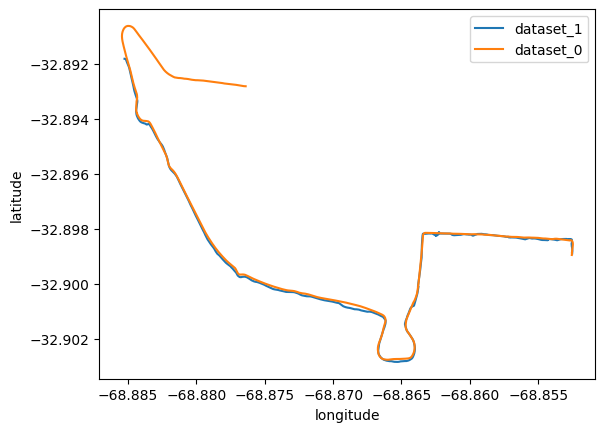

19/19 [==============================] - 0s 4ms/step


Text(0.5, 0, 'sample')

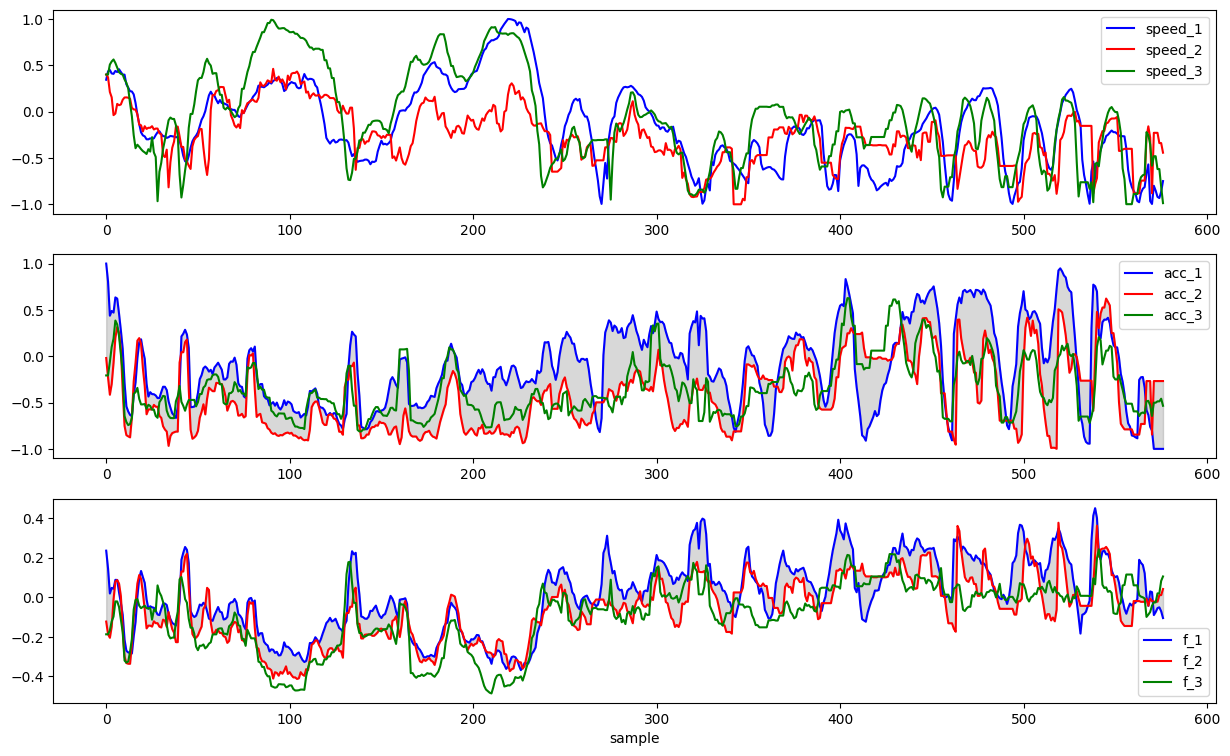

In [25]:
# Dataset 3
i_ini, i_fin = 10, 800 # s
loc_orig_df_3, acc_orig_df_3 = load_dataset_n('913_1', i_ini, i_fin)
acc_feat_df_3 = rolling_rms(acc_orig_df_3)
features_lf_3 = calc_features_lf_n(loc_orig_df_3, acc_feat_df_3)
_, loc_orig_df_3_matched, features_lf_3_matched = times_matches_1_n(loc_orig_df_1, loc_orig_df_3, features_lf_3)

X_1 = X_equal[:, :2]
X_2 = X_equal[:, 2:]
X_3 = scaler_X.transform(np.array([features_lf_3_matched.loc[:, 'speed'].values, 
                                   features_lf_3_matched.loc[:, 'z_rolling_rms'].values]).T)
x1_3_pred = model_x1.predict([X_3])

fig, ax = plt.subplots(3, 1, figsize=(15,9))
ax[0].plot(X_1[:, 0], color='blue', linestyle='-', label='speed_1')
ax[0].plot(X_2[:, 0], color='red', linestyle='-', label='speed_2')
ax[0].plot(X_3[:, 0], color='green', linestyle='-', label='speed_3')
ax[0].legend()

ax[1].plot(X_1[:, 1], color='blue', linestyle='-', label='acc_1')
ax[1].plot(X_2[:, 1], color='red', linestyle='-', label='acc_2')
ax[1].plot(X_3[:, 1], color='green', linestyle='-', label='acc_3')
ax[1].fill_between(np.linspace(0,x1_1_pred.shape[0]-1,x1_1_pred.shape[0]), 
                   (X_equal[:, 1]).ravel(), 
                   (X_equal[:, 3]).ravel(), 
                   color='grey', alpha=0.3)  # Adjust alpha for transparency if needed
ax[1].legend()

ax[2].plot(x1_1_pred, color='blue', linestyle='-', label='f_1')
ax[2].plot(x1_2_pred, color='red', linestyle='-', label='f_2')
ax[2].plot(x1_3_pred, color='green', linestyle='-', label='f_3')
ax[2].fill_between(np.linspace(0,x1_1_pred.shape[0]-1,x1_1_pred.shape[0]), 
                   (x1_1_pred).ravel(), 
                   (x1_2_pred).ravel(), 
                   color='grey', alpha=0.3)  # Adjust alpha for transparency if needed
ax[2].legend()
ax[2].set_xlabel('sample')


# FFT of raw acc

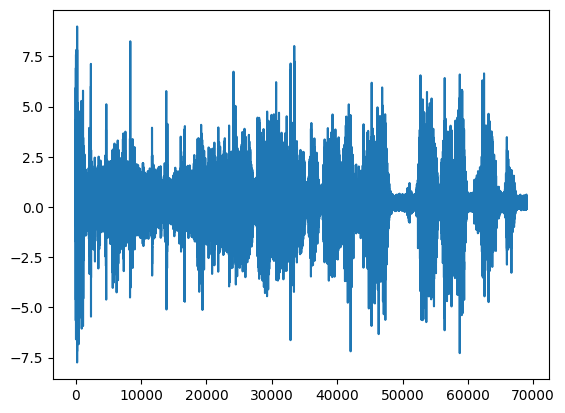

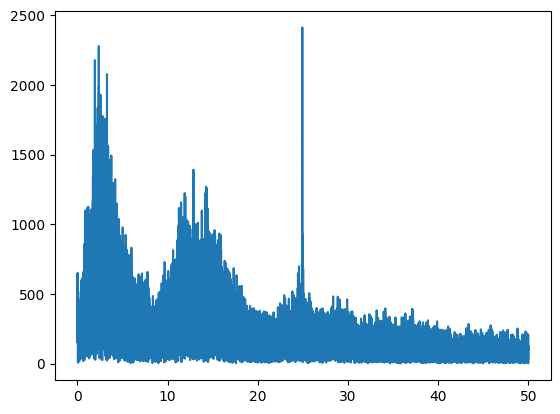

In [26]:
from scipy import fft


freqs = fft.fftfreq(acc_orig_df_1['z'].values.shape[0], 1/100)[1:acc_orig_df_1['z'].values.shape[0]//2]
plt.plot(acc_orig_df_1['z'])
plt.figure()
plt.plot(freqs,
         abs(fft.fft(acc_orig_df_1['z'].values - np.mean(acc_orig_df_1['z'].values))[1:acc_orig_df_1['z'].values.shape[0]//2]))
# plt.ylim([0,500])
